In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import joblib
import tensorflow as tf
import keras
import os, time
from IPython.display import clear_output 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_X_data(list_):
    sample_n = 180
    length = len(list_)

    X = []

    for i in range(length//sample_n):

        X.append(list_[i*sample_n:sample_n*(i+1)])

    X = np.array(X).reshape(-1, 180, 3)
    return X

def delete_nan(X, y):
    delete_idx = []

    for idx, X_ in enumerate(X):
        if np.isnan(X_).sum() != 0:
            delete_idx.append(idx)
    
    return np.delete(X,delete_idx, axis = 0), to_categorical(np.delete(y,delete_idx, axis = 0))

def get_feature(X):
    feature = []

    for sample in X:
        tmp = sample[:,:].max(axis=0).tolist() + sample[:,:].min(axis=0).tolist() + sample[:,:].mean(axis=0).tolist() + sample[:,:].std(axis=0).tolist()
        feature.append(tmp)

    return np.array(feature)

def test_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train, y_train.argmax(axis=1))
    
    pred = rf.predict(X_test)
    
    return rf, accuracy_score(y_test.argmax(axis=1), pred)

### 회귀 보간X 데이터 Load

In [3]:
ADS_df = pd.read_csv("./custom_data/ADS_df_no_interpolation.csv", index_col=0)

GGG_df = pd.read_csv("./custom_data/GGG_df_no_interpolation.csv", index_col=0)
GGI_df = pd.read_csv("./custom_data/GGI_df_no_interpolation.csv", index_col=0)
GGJ_df = pd.read_csv("./custom_data/GGJ_df_no_interpolation.csv", index_col=0)

GD_df = pd.read_csv("./custom_data/GD_df_no_interpolation.csv", index_col=0)

GGG_df[['X','Y','Z']] = GGG_df[['X','Y','Z']].interpolate(method='linear', limit=5)
GGI_df[['X','Y','Z']] = GGI_df[['X','Y','Z']].interpolate(method='linear', limit=5)
GGJ_df[['X','Y','Z']] = GGJ_df[['X','Y','Z']].interpolate(method='linear', limit=5)

### 회귀 보간O 데이터 Load

In [4]:
# rg_interpolation_df = pd.read_csv("./custom_data/rg_interpolation.csv", index_col=0)

# GGG_df = pd.DataFrame()
# GGI_df = pd.DataFrame()
# GGJ_df = pd.DataFrame()

# GGG_df[['X','Y','Z']] = rg_interpolation_df[['Bx_Gangneung','By_Gangneung','Bz_Gangneung']].interpolate(method='linear', limit=5)
# GGI_df[['X','Y','Z']] = rg_interpolation_df[['Bx_Icheon','By_Icheon','Bz_Icheon']].interpolate(method='linear', limit=5)
# GGJ_df[['X','Y','Z']] = rg_interpolation_df[['Bx_Jeju','By_Jeju','Bz_Jeju']].interpolate(method='linear', limit=5)

# GD_df = pd.read_csv("./custom_data/GD_df_no_interpolation.csv", index_col=0)

### 정규화 수행

In [5]:
# min_max_scaler = preprocessing.StandardScaler()
# GGG_df[['X','Y','Z']] = min_max_scaler.fit_transform(GGG_df[['X','Y','Z']])
# GGI_df[['X','Y','Z']] = min_max_scaler.fit_transform(GGI_df[['X','Y','Z']])
# GGJ_df[['X','Y','Z']] = min_max_scaler.fit_transform(GGJ_df[['X','Y','Z']])

### 입력 형태로 변환 / (m,180,3) format

In [6]:
# 입력 데이터
GGG_X = make_X_data(GGG_df[['X','Y','Z']].values.tolist())
GGI_X = make_X_data(GGI_df[['X','Y','Z']].values.tolist())
GGJ_X = make_X_data(GGJ_df[['X','Y','Z']].values.tolist())

print(np.shape(GGG_X), np.shape(GGI_X), np.shape(GGJ_X))

# 출력 데이터
y = GD_df['Geo_Dist'].values.reshape(-1,1)

print(np.shape(y))

(23376, 180, 3) (23376, 180, 3) (23376, 180, 3)
(23376, 1)


### 데이터 조합 및 nan값 처리

In [7]:
GI_X = np.concatenate([GGG_X, GGI_X], axis=2)
GJ_X = np.concatenate([GGG_X, GGJ_X], axis=2)
IJ_X = np.concatenate([GGI_X, GGJ_X], axis=2)

GIJ_X = np.concatenate([GGG_X, GGI_X, GGJ_X], axis=2)

# 조합 X
GGG_X, GGG_y = delete_nan(GGG_X, y)
GGI_X, GGI_y = delete_nan(GGI_X, y)
GGJ_X, GGJ_y = delete_nan(GGJ_X, y)

# 조합 O
GI_X, GI_y = delete_nan(GI_X, y)
GJ_X, GJ_y = delete_nan(GJ_X, y)
IJ_X, IJ_y = delete_nan(IJ_X, y)

GIJ_X, GIJ_y = delete_nan(GIJ_X, y)

In [8]:
print(np.shape(GIJ_y))

(18915, 8)


### 사용할 데이터 길이 설정
현재 시점에서 과거로 어느 시점까지만 입력에 사용할지에 대한 처리 [(t-180+d) ~(t)]

In [9]:
distance = 0

GGG_X = GGG_X[:,distance:,:]
GGI_X = GGI_X[:,distance:,:]
GGJ_X = GGJ_X[:,distance:,:]

GI_X = GI_X[:,distance:,:]
GJ_X = GJ_X[:,distance:,:]
IJ_X = IJ_X[:,distance:,:]

GIJ_X = GIJ_X[:,distance:,:]

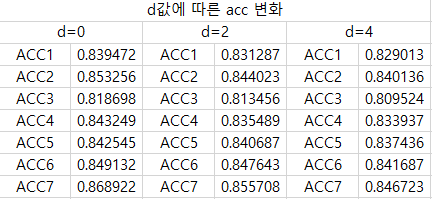

실험결과 180분(3시간) 데이터를 모두 사용하는 것이 가장 효과적
d가 늘어날 수록 acc가 줄어듦.

### 차분할 간격 설정

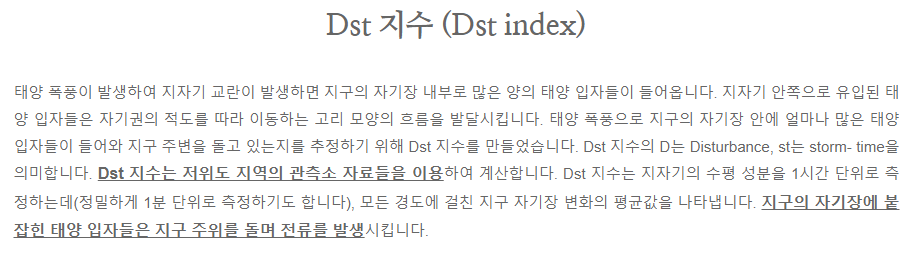

지구 자기장 "변화"의 평균값이므로 차분을 통해 변화에 대한 정보를 feature로 사용하기로 결정

In [10]:
gap = 42#34

In [11]:
G_diff_X = GGG_X[:,0:180-gap-distance,:] - GGG_X[:,gap:180-distance,:]
I_diff_X = GGI_X[:,0:180-gap-distance,:] - GGI_X[:,gap:180-distance,:]
J_diff_X = GGJ_X[:,0:180-gap-distance,:] - GGJ_X[:,gap:180-distance,:]

GI_diff_X = GI_X[:,0:180-gap-distance,:] - GI_X[:,gap:180-distance,:]
GJ_diff_X = GJ_X[:,0:180-gap-distance,:] - GJ_X[:,gap:180-distance,:]
IJ_diff_X = IJ_X[:,0:180-gap-distance,:] - IJ_X[:,gap:180-distance,:]

GIJ_diff_X = GIJ_X[:,0:180-gap-distance,:] - GIJ_X[:,gap:180-distance,:]

시험 결과 gap이 40 ~ 42사이가 가장 효과적임.

다음의 엑셀은 data를 train, test로 나눠 train으로 학습후 test에 대한 acc를 출력한 것입니다.<br>
ACC가 7개인 이유는 각 관측소의 조합에 따라 7가지 type이 나오기 때문

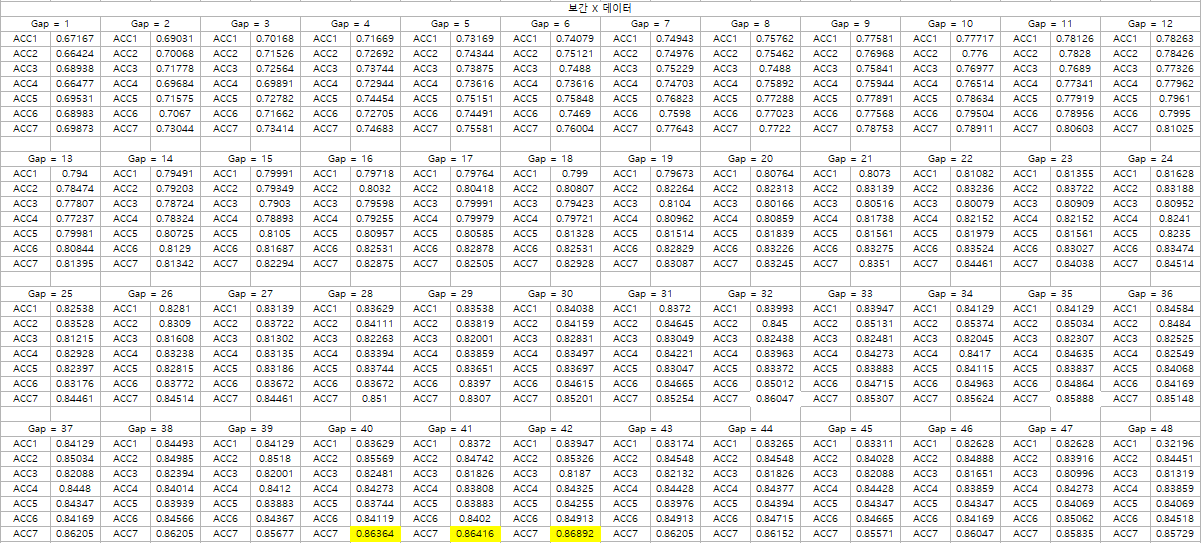

### feature 추출(min, max, avg, std)

In [12]:
G_diff_feature_X = get_feature(G_diff_X)
I_diff_feature_X = get_feature(I_diff_X)
J_diff_feature_X = get_feature(J_diff_X)

GI_diff_feature_X = get_feature(GI_diff_X)
GJ_diff_feature_X = get_feature(GJ_diff_X)
IJ_diff_feature_X = get_feature(IJ_diff_X)

GIJ_diff_feature_X = get_feature(GIJ_diff_X)

In [13]:
total_data = {'G  ':[G_diff_feature_X, GGG_y], 'I  ':[I_diff_feature_X, GGI_y], 'J  ':[J_diff_feature_X, GGJ_y],
             'GI ':[GI_diff_feature_X, GI_y], 'GJ ':[GJ_diff_feature_X, GJ_y], 'IJ ':[IJ_diff_feature_X, IJ_y],
             'GIJ':[GIJ_diff_feature_X, GIJ_y]}

In [14]:
rf = []
acc = []
for idx, name in enumerate(total_data.keys()):
    rf_, acc_ = test_rf(total_data[name][0], total_data[name][1])
    rf.append(rf_)
    acc.append(acc_)
    print("({}) 조합 {} Accuracy : {}%".format(idx, name, round(acc_, 4)))

(0) 조합 G   Accuracy : 0.8395%
(1) 조합 I   Accuracy : 0.8533%
(2) 조합 J   Accuracy : 0.8187%
(3) 조합 GI  Accuracy : 0.8432%
(4) 조합 GJ  Accuracy : 0.8425%
(5) 조합 IJ  Accuracy : 0.8491%
(6) 조합 GIJ Accuracy : 0.8689%


### 모델 Save

In [15]:
joblib.dump(rf[6], './final_model/rfgap42test_size0_1.pkl')

['./final_model/rfgap42test_size0_1.pkl']

### 모델 Load

In [16]:
loaded_model = joblib.load('./final_model/rfgap42test_size0_1.pkl')

### Quiz 데이터 Load

In [17]:
Q_GGG_df = pd.read_csv("./Quiz/GGG_df_interpolation.csv", index_col=0)
Q_GGI_df = pd.read_csv("./Quiz/GGI_df_interpolation.csv", index_col=0)
Q_GGJ_df = pd.read_csv("./Quiz/GGJ_df_interpolation.csv", index_col=0)

### 선형 보간

In [18]:
Q_GGG_df[['X','Y','Z']] = Q_GGG_df[['X','Y','Z']].interpolate(method='linear', limit=5)
Q_GGI_df[['X','Y','Z']] = Q_GGI_df[['X','Y','Z']].interpolate(method='linear', limit=5)
Q_GGJ_df[['X','Y','Z']] = Q_GGJ_df[['X','Y','Z']].interpolate(method='linear', limit=5)

### 앞써 학습한 모델의 Input의 형태로 맞춰줌.

In [19]:
# 입력 데이터
Q_G_X = make_X_data(Q_GGG_df[['X','Y','Z']].values.tolist())
Q_I_X = make_X_data(Q_GGI_df[['X','Y','Z']].values.tolist())
Q_J_X = make_X_data(Q_GGJ_df[['X','Y','Z']].values.tolist())

Q_GI_X = np.concatenate([Q_G_X, Q_I_X], axis=2)
Q_GJ_X = np.concatenate([Q_G_X, Q_J_X], axis=2)
Q_IJ_X = np.concatenate([Q_I_X, Q_J_X], axis=2)

Q_GIJ_X = np.concatenate([Q_G_X, Q_I_X, Q_J_X], axis=2)

In [20]:
# gap = 1 #위에서 설정한 gap과 동일

Q_G_diff_X = Q_G_X[:,0:180-gap,:] - Q_G_X[:,gap:180,:]
Q_I_diff_X = Q_I_X[:,0:180-gap,:] - Q_I_X[:,gap:180,:]
Q_J_diff_X = Q_J_X[:,0:180-gap,:] - Q_J_X[:,gap:180,:]

Q_GI_diff_X = Q_GI_X[:,0:180-gap,:] - Q_GI_X[:,gap:180,:]
Q_GJ_diff_X = Q_GJ_X[:,0:180-gap,:] - Q_GJ_X[:,gap:180,:]
Q_IJ_diff_X = Q_IJ_X[:,0:180-gap,:] - Q_IJ_X[:,gap:180,:]

Q_GIJ_diff_X = Q_GIJ_X[:,0:180-gap,:] - Q_GIJ_X[:,gap:180,:]

# 조합 X
Q_G_diff_feature_X = get_feature(Q_G_diff_X)
Q_I_diff_feature_X = get_feature(Q_I_diff_X)
Q_J_diff_feature_X = get_feature(Q_J_diff_X)

# 조합 O
Q_GI_diff_feature_X = get_feature(Q_GI_diff_X)
Q_GJ_diff_feature_X = get_feature(Q_GJ_diff_X)
Q_IJ_diff_feature_X = get_feature(Q_IJ_diff_X)

Q_GIJ_diff_feature_X = get_feature(Q_GIJ_diff_X)

### Quiz 데이터 예측

In [21]:
pred = loaded_model.predict(Q_GIJ_diff_feature_X)

### 마지막 480개만을 답안으로 제출

In [22]:
pred[240:]

array([5, 6, 4, 3, 2, 4, 3, 4, 3, 3, 2, 1, 1, 2, 3, 2, 3, 3, 2, 0, 0, 1,
       0, 2, 3, 3, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 1, 0, 1, 2, 3, 3, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 1, 2, 1, 5, 6, 5, 4, 4, 4, 3, 4, 2, 3, 3, 3,
       2, 2, 2, 2, 1, 2, 3, 3, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1,
       2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 3, 5, 3, 3, 3, 3, 3, 3, 3, 2, 1,
       1, 3, 3, 2, 2, 1, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 1, 2, 2, 2, 2, 0,
       1, 1, 2, 2, 3, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 0, 2, 2, 3,
       2, 0, 0, 2, 1, 2, 2, 3, 3, 2, 1, 2, 2, 2, 2, 3, 2, 3, 1, 1, 1, 2,
       3, 3, 3, 2, 1, 0, 0, 2, 3, 3, 2, 1, 0, 0, 0, 2, 3, 3, 3, 0, 0, 1,
       1, 2, 3, 2, 2, 1, 1, 1, 2, 2, 3, 3, 2, 1, 0, 0, 1, 2, 3, 2, 1, 3,
       2, 1, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3,
       2, 2, 3, 1, 2, 3, 3, 3, 2, 2, 1, 1, 0, 3, 3, 2, 2, 1, 1, 1, 1, 3,
       3, 3, 2, 2, 1, 4, 2, 2, 3, 3, 1, 2, 1, 2, 0, 3, 3, 3, 1, 2, 1, 2,
       2, 2, 3, 3, 3, 3, 3, 1, 2, 2, 2, 3, 2, 1, 1,

### 제출과정

pred를 그대로 복사하여 개인 컴퓨터 파일에 list_에 넣음

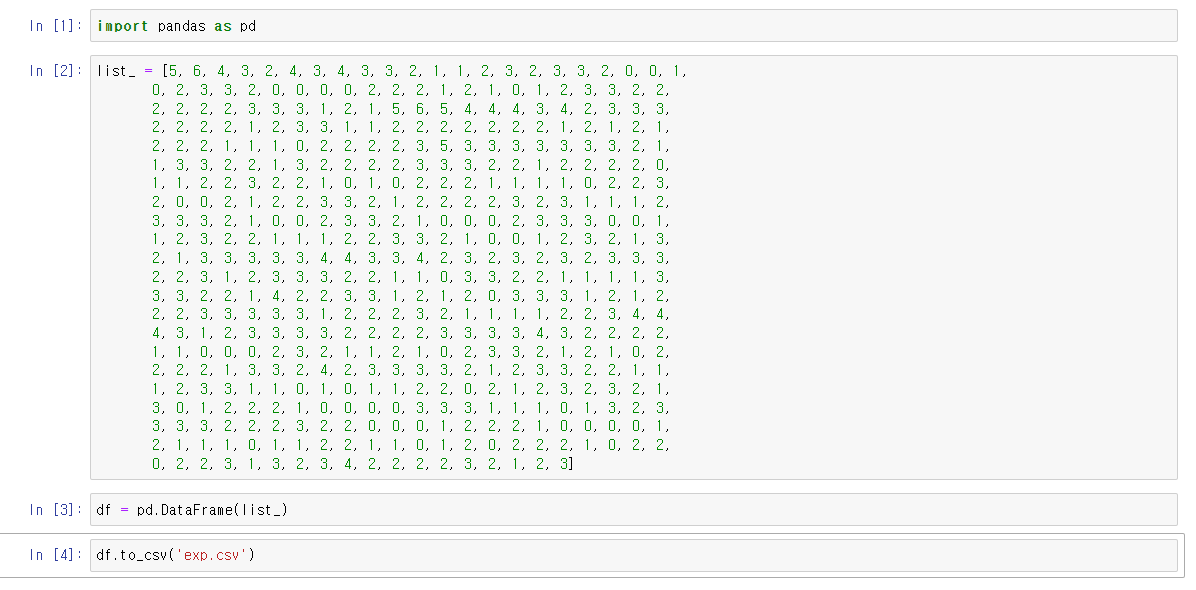

생성된 exp.csv 파일에서 위와 같이 복사

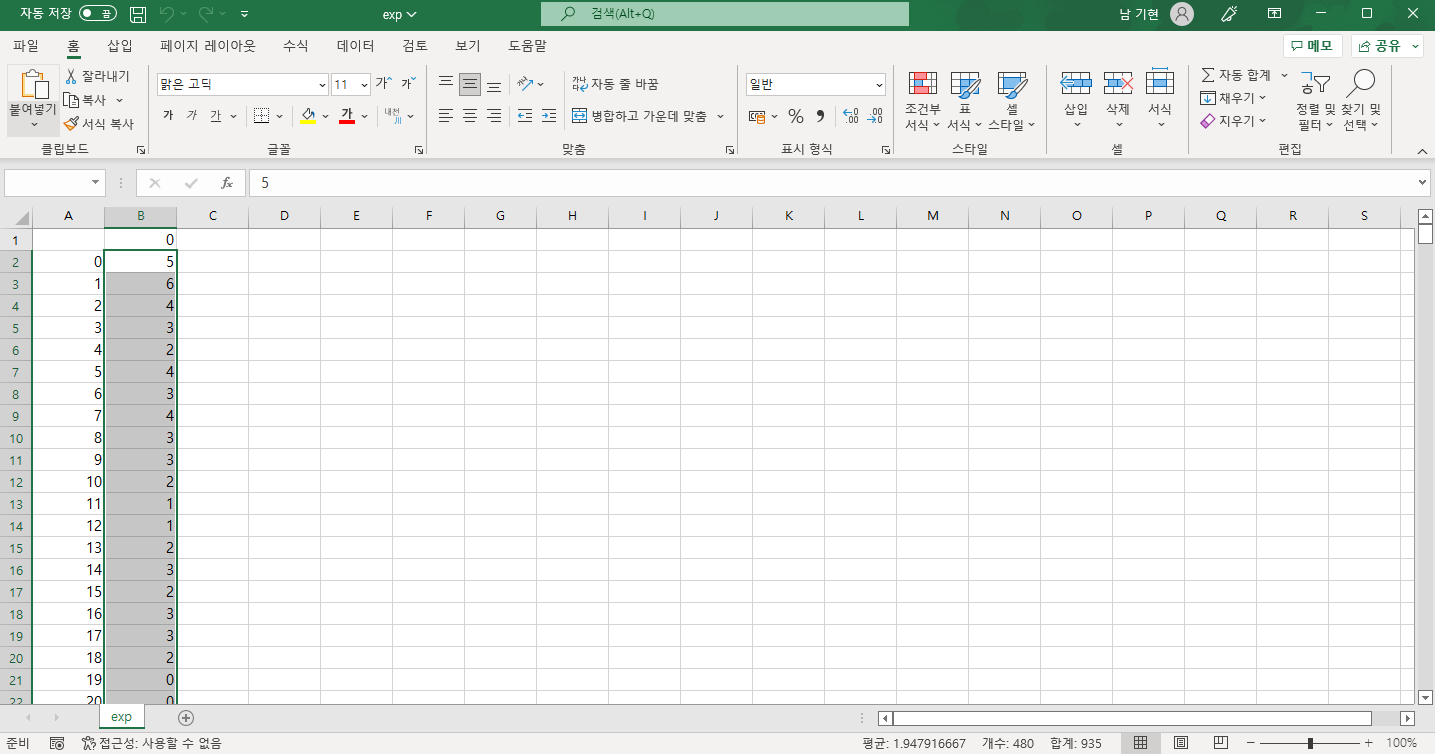

그대로 정답 템플렛에 넣음

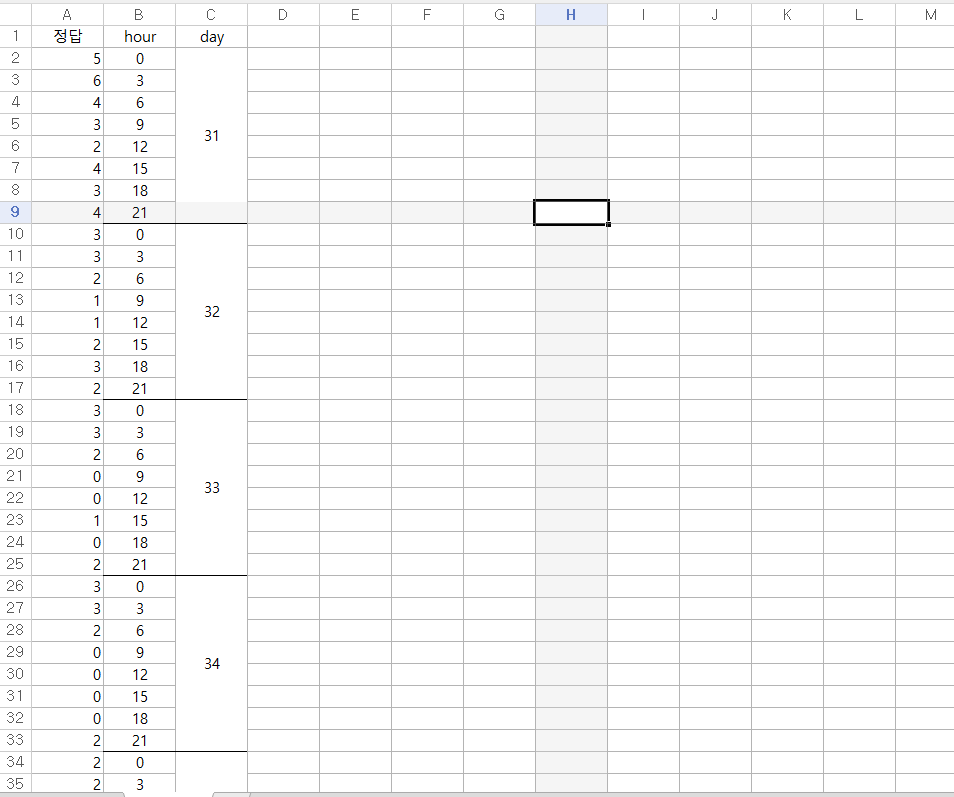